In [1]:
import keras

D:\development\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
import numpy as np
import csv
import pandas as pd

In [6]:
from os import listdir

In [7]:
def load_data(directory):
    filenames = listdir(directory)
    
    data = list()
    for filename in filenames:
        with open(directory + filename, 'r') as f:
            data.append(pd.read_csv(f))
    return data

In [8]:
datas = load_data('D:/development/python-projects/mozart-tabs/')

In [9]:
df = pd.concat(datas)
df.shape

(531808, 108)

In [10]:
train_part = int(df.shape[0] * 0.8)

train = df.iloc[:train_part]
test = df.iloc[train_part:]

In [114]:
from keras.layers import Input, Dense, Reshape
from keras.models import Model

def create_dense_ae():
    
    input_dim = 108
    
    encoding_dim_1 = 10
    encoding_dim_2 = 5
    encoding_dim_3 = 3
    
    input_l = Input(shape=(input_dim,))
    
    encoded_1 = Dense(encoding_dim_1, activation='sigmoid')(input_l)
    encoded_2 = Dense(encoding_dim_2, activation='relu')(encoded_1)
    encoded_3 = Dense(encoding_dim_3, activation='linear')(encoded_2)
    
    input_encoded = Input(shape=(encoding_dim_3,))
    
    decoded_1 = Dense(encoding_dim_2, activation='sigmoid')(input_encoded)
    decoded_2 = Dense(encoding_dim_1, activation='relu')(decoded_1)
    decoded_3 = Dense(input_dim, activation='sigmoid')(input_encoded)
    
    encoder = Model(input_l, encoded_3, name="encoder")
    decoder = Model(input_encoded, decoded_3, name="decoder")
    
    autoencoder = Model(input_l, decoder(encoder(input_l)), name="autoencoder")
    
    return encoder, decoder, autoencoder

In [115]:
encoder, decoder, autoencoder = create_dense_ae()

In [116]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [117]:
autoencoder.fit(train, train, epochs=10, batch_size=256,
                shuffle=True, validation_data=(test, test))

Train on 425446 samples, validate on 106362 samples
Epoch 1/10
425446/425446 [==============================] - 22s 53us/step - loss: 0.0918 - val_loss: 0.0294
Epoch 2/10
425446/425446 [==============================] - 21s 49us/step - loss: 0.0346 - val_loss: 0.0234
Epoch 3/10
425446/425446 [==============================] - 21s 49us/step - loss: 0.0289 - val_loss: 0.0211
Epoch 4/10
425446/425446 [==============================] - 22s 51us/step - loss: 0.0266 - val_loss: 0.0186
Epoch 5/10
425446/425446 [==============================] - 21s 49us/step - loss: 0.0209 - val_loss: 0.0136
Epoch 6/10
425446/425446 [==============================] - 22s 51us/step - loss: 0.0175 - val_loss: 0.0118
Epoch 7/10
425446/425446 [==============================] - 21s 50us/step - loss: 0.0161 - val_loss: 0.0111
Epoch 8/10
425446/425446 [==============================] - 22s 51us/step - loss: 0.0152 - val_loss: 0.0105
Epoch 9/10
425446/425446 [==============================] - 22s 51us/step - loss: 0.

In [212]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [94]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [ ]:
# for all songs
# encode with encoder
# use as train set for LSTM

# work mode:
# frame->encode->to LSTM->decode-> ???? -> PROFIT!b

In [118]:
lstm_train_datas = list()
for d in datas:
    encoded_data = encoder.predict(d)
    lstm_train_datas.append(encoded_data)



In [119]:
lstm_dataset = [create_dataset(i) for i in lstm_train_datas]

In [231]:
look_back = 1
features_num = encoder.output_shape[1]

# TEMP
features_num = 108
lstm_dataset = [create_dataset(i.as_matrix()) for i in datas]
###

lstm_model = Sequential()
lstm_model.add(LSTM(512, return_sequences=True, input_shape=(look_back, features_num)))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(512, return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(512))
lstm_model.add(Dense(256))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(features_num, activation='softmax'))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')


for batch in lstm_dataset[:5]:
    lstm_model.fit(batch[0], batch[1], epochs=1)
#     lstm_model.train_on_batch(batch[0], batch[1])
    print('\nNext track')

Epoch 1/1
5120/5120 [==============================] - 76s 15ms/step - loss: 0.0071

Next track
Epoch 1/1
7296/7296 [==============================] - 85s 12ms/step - loss: 0.0070

Next track
Epoch 1/1
7296/7296 [==============================] - 85s 12ms/step - loss: 0.0039

Next track
Epoch 1/1
7552/7552 [==============================] - 87s 12ms/step - loss: 0.0021

Next track
Epoch 1/1
5376/5376 [==============================] - 62s 12ms/step - loss: 0.0021

Next track


In [248]:

for batch in lstm_dataset[5:]:
    lstm_model.fit(batch[0], batch[1], epochs=1)

Epoch 1/1
2304/2304 [==============================] - 27s 12ms/step - loss: 0.0088
Epoch 1/1
14208/14208 [==============================] - 166s 12ms/step - loss: 0.0048
Epoch 1/1
5120/5120 [==============================] - 59s 12ms/step - loss: 0.0075
Epoch 1/1
8704/8704 [==============================] - 102s 12ms/step - loss: 0.0044
Epoch 1/1
8832/8832 [==============================] - 103s 12ms/step - loss: 0.0028
Epoch 1/1
6912/6912 [==============================] - 81s 12ms/step - loss: 0.0012
Epoch 1/1
4992/4992 [==============================] - 58s 12ms/step - loss: 0.0025
Epoch 1/1
17920/17920 [==============================] - 212s 12ms/step - loss: 0.0013
Epoch 1/1
7808/7808 [==============================] - 93s 12ms/step - loss: 0.0012
Epoch 1/1
7808/7808 [==============================] - 93s 12ms/step - loss: 9.6569e-04
Epoch 1/1
3712/3712 [==============================] - 45s 12ms/step - loss: 0.0022
Epoch 1/1
2560/2560 [==============================] - 31s 12ms/

In [251]:
# https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5
lstm_model.save('lstm-only.h5')
# from keras.models import load_model
# lstm_model = load_model

In [20]:
START = datas[0].iloc[0].as_matrix()
END = datas[0].iloc[-1].as_matrix()

In [234]:
# # TEMP
def predict(timestep):
    return lstm_model.predict(timestep.reshape(1,-1)[np.newaxis,:])

In [106]:


def predict(timestep):
    encoded = encoder.predict(timestep.reshape(1,-1))
    prediction = lstm_model.predict(encoded[np.newaxis, :])
    return decoder.predict(prediction)

def threshold(timestep, thresh=0.5):
    timestep[timestep >= thresh] = 1
    timestep[timestep <= thresh] = 0
    return timestep

In [278]:
np.random.uniform(size=(1,108))

NameError: name 'f' is not defined

In [287]:
song = list()
last_step = START#train.iloc[1].as_matrix()
for i in range(500):
    prediction = predict(last_step + np.random.uniform(low=-1.0, size=(1,108)))
    song.append(prediction)
    last_step = prediction

In [267]:
out1 = predict(np.array([1] * 108))
out2 = predict(END)
out3 = predict(out2)
out4 = predict(out3)

In [269]:
np.argmax(out1)

72

In [286]:
np.mean(song)

0.009259259

In [285]:
np.max(song)

1.0

In [292]:
def process(data):
    base_labels = 'c c# d d# e f f# g g# a a# b'.split()

    # note_label + octave_num
    features = np.array([l + str(i) for i in range(0,9) for l in base_labels])
    song = []
    for i in data:
#         if  np.argmax(i) in list(range(9)):
#             continue
        song.append((features[np.argmax(i)], 4))
    return song

In [188]:
a = np.array([2,34,5])

In [193]:
[2,3,4] in a

True

In [275]:
set(play)

{('c6', 128)}

In [23]:
import matplotlib.pyplot as plt

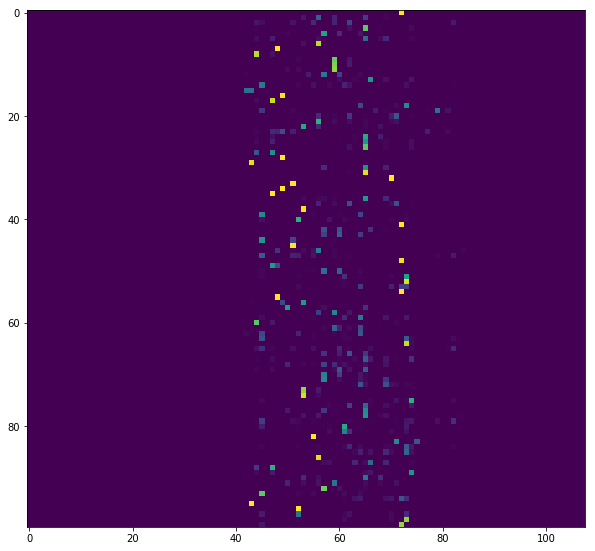

In [288]:
s = np.array(song)
plt.figure(figsize=(10,14))
plt.imshow(np.exp(s[:100].reshape(100, -1)))
plt.show()

In [175]:
import pysynth

Piano key frequencies (for equal temperament):
Key number	Scientific name	Frequency (Hz)
         1	             A0	         27.50
         2	            A#0	         29.14
         3	             B0	         30.87
         4	             C1	         32.70
         5	            C#1	         34.65
         6	             D1	         36.71
         7	            D#1	         38.89
         8	             E1	         41.20
         9	             F1	         43.65
        10	            F#1	         46.25
        11	             G1	         49.00
        12	            G#1	         51.91
        13	             A1	         55.00
        14	            A#1	         58.27
        15	             B1	         61.74
        16	             C2	         65.41
        17	            C#2	         69.30
        18	             D2	         73.42
        19	            D#2	         77.78
        20	             E2	         82.41
        21	             F2	         87.31
        22	            F#2	  

In [294]:
import pysynth_b as synth
play = process(song)
synth.make_wav(play, fn='out-v6.wav')

[1/500]	
[5/500]	
[9/500]	
[13/500]	
[17/500]	
[21/500]	
[25/500]	
[29/500]	
[33/500]	
[37/500]	
[41/500]	
[45/500]	
[49/500]	
[53/500]	
[57/500]	
[61/500]	
[65/500]	
[69/500]	
[73/500]	
[77/500]	
[81/500]	
[85/500]	
[89/500]	
[93/500]	
[97/500]	
[101/500]	
[105/500]	
[109/500]	
[113/500]	
[117/500]	
[121/500]	
[125/500]	
[129/500]	
[133/500]	
[137/500]	
[141/500]	
[145/500]	
[149/500]	
[153/500]	
[157/500]	
[161/500]	
[165/500]	
[169/500]	
[173/500]	
[177/500]	
[181/500]	
[185/500]	
[189/500]	
[193/500]	
[197/500]	
[201/500]	
[205/500]	
[209/500]	
[213/500]	
[217/500]	
[221/500]	
[225/500]	
[229/500]	
[233/500]	
[237/500]	
[241/500]	
[245/500]	
[249/500]	
[253/500]	
[257/500]	
[261/500]	
[265/500]	
[269/500]	
[273/500]	
[277/500]	
[281/500]	
[285/500]	
[289/500]	
[293/500]	
[297/500]	
[301/500]	
[305/500]	
[309/500]	
[313/500]	
[317/500]	
[321/500]	
[325/500]	
[329/500]	
[333/500]	
[337/500]	
[341/500]	
[345/500]	
[349/500]	
[353/500]	
[357/500]	
[361/500]	
[365/500]	
[369/500]	
[373/